# Notebook to browse tree and find pair of relatives
A Package that can crowl pedigree data and return the pw. relatedness of every pair

In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import socket as socket
import os as os
import sys as sys
import h5py
import matplotlib.cm as cm
import itertools as it
import multiprocessing as mp
from queue import Queue
import itertools as it

socket_name = socket.gethostname()
print(socket_name)

if socket_name.startswith("compute-"):
    print("HSM O2 Computational partition detected.")
    path = "/n/groups/reich/hringbauer/"  # The Path on Harvard Cluster
    sys.path.insert(0,"/n/groups/reich/hringbauer/git/hapBLOCK/python3/")  # hack to get development package first in path
    
elif socket_name.startswith("bionc"):
    print("Leipzig Cluster detected!")
    path = "/mnt/archgen/users/hringbauer/git/ibd_gurgy/"
    sys.path.append("/mnt/archgen/users/hringbauer/git/hapBLOCK/python3/") 
    
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")

os.chdir(path)  # Set the right Path (in line with Atom default)
print(os.getcwd())
print(f"CPU Count: {mp.cpu_count()}")

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'   # Set the defaul
rcParams['font.sans-serif'] = ['Arial']

from ibd_stats.funcs import find_relatives

bionc21
Leipzig Cluster detected!
/mnt/archgen/users/hringbauer/git/ibd_gurgy
CPU Count: 40


### Create a list of nodes

In [158]:
########################################
### The node object

class Ind(object):
    """Class that stores parents, and whether visited."""
    name = ""
    mum = ""
    dad = ""
    output = False
    anc = -1 # How far away from a given sample
    anc1 = -1 # How far away from given sample 2
    
    def __init__(self, name="", mum="", dad=""):
        if len(name)>0:
            self.name = name   
        if len(mum)>0:
            self.set_mum(mum)  
        if len(dad)>0:
            self.set_dad(dad)
            
    def set_mum(self, mum):
        """Set Mum."""
        self.mum = mum
        
    def set_dad(self, dad):
        """Set Data"""
        self.dad = dad
        
    def get_mum(self):
        """Get Mum."""
        return self.mum
        
    def get_dad(self):
        """Get Dad"""
        return self.dad
    
    def get_parents(self):
        """Get Mum and Dad"""
        return self.mum, self.dad
        
    def show(self):
        """Print Summary Stats"""
        print(f"Name: {self.name}")
        print(f"Mum: {self.mum}")
        print(f"Dad: {self.dad}")
        

########################################
### Function to set up the tree       
        
def set_up_node_list(df, dummy_nodes=True):
    """Set up List of all Nodes.
    Initialize to parent values.
    dummy_nodes: Whether to initialize parent nodes that are not targets."""

    names = df["t"].values
    
    ### Make nodes for all target indivduals
    inds = np.array([Ind(name=t) for t in names])
    print(f"Created {len(inds)} target Nodes")
    
    ### Make nodes for all parents not in targets
    if dummy_nodes:
        ps = set(np.append(df["f"].values, df["m"].values)) # unique parents
        ps = [p for p in ps if p not in names]
        inds1 = np.array([Ind(name=p) for p in ps])
        print(f"Created {len(inds1)} parent dummy nodes")
        # Update name and node list to include parent dummy nodes
        names = np.append(names,ps)
        inds = np.append(inds,inds1)  
        
    ### Set all parents
    for i, row in df.iterrows():
        ind = inds[i]

        mum, dad = row["f"], row["m"]
        idx_m =  np.where(names==mum)[0]
        idx_d =  np.where(names==dad)[0]
        assert(len(idx_m)<2) # Sanity Check
        assert(len(idx_d)<2)
        
        # Set existing parantes
        if len(idx_m)>0: 
            mum = inds[idx_m[0]]
        ind.set_mum(mum)

        if len(idx_d)>0:
            dad = inds[idx_d[0]]
        ind.set_dad(dad)
        
    return inds

def reset_ancs(inds):
    """Reset all ancestors to missing"""
    for i in inds:
        i.anc = -1
        i.anc1 = -1
        
def set_ancs(node, anc=0, output=False):
    """Starting from a Node, crawl
    to ancestors. 
    Recursively set their distance to the original node.
    Return number of all ancestors in pedigree"""
    if output:
        print(f"Crowling Node {node.name}")
    if node.anc == -1:
        node.anc=anc
        
    mum, dad = node.get_parents()
    
    # Recursively go to ancestors
    ancs1, ancs2 = 0, 0
    if isinstance(node.mum, Ind):
        ancs1 = set_ancs(node.mum, anc+1, output=output)
        
    if isinstance(node.dad, Ind):
        ancs2 = set_ancs(node.dad, anc+1, output=output)
    
    return ancs1 + ancs2 + 1


########################################
### Function to crawl the tree  

def find_node(name, inds):
    """Return Node of name name."""
    for i in inds:
        if i.name==name:
            return i
    raise RuntimeWarning(f"Individual {name} not found in Ind list")
    
def find_common_ancs(node, anc1=0, output=False):
    """Starting from Node, crawl to ancestors.
    Return all common ancestors.
    Runs breadth-first algorithm and detects first hit.
    Returns: dist to anc1 [int], dist to anc2 [int], half-sib [bool]"""
    if output:
        print(f"Crowling Node {node.name}")
    
    if node.anc1 == -1:
        node.anc1=anc1
        
    #### If ancestor of other indiviudal found - return
    if node.anc>=0:
        return node.anc, node.anc1, 0  # anc
    
    #### Crowl to parents    
    mum, dad = node.get_parents()
    
    if isinstance(node.mum, Ind):
        found = find_common_ancs(node.mum, anc1+1, output=output)
        if found:
            ### Check if connection via dad too: in thac case: must be full sib
            if isinstance(node.dad, Ind):
                found2 = find_common_ancs(node.dad, anc1+1, output=output)
            else:
                found2 = None 
            ### Set to full sib if mum and dad indeed agree    
            if found == found2:
                return found[0], found[1], 1
            else:
                return found
            
    if isinstance(node.dad, Ind):
        found = find_common_ancs(node.dad, anc1+1, output=output)
        if found:
            return found
        
    ### Return if Nothing found
    return False

def get_degree(anc1, anc2, fs=False):
    """Return the degree of ancestry, and whether one or two ancestors in common"""
    
    ### One directly ancestral to the other
    if (anc1 == 0) or (anc2 == 0):
        return (anc1 + anc2, True)
    
    ### Via Full-Sib:
    elif fs == 1:    
            return (anc1 + anc2 -1, False)
    
    ### Via Half-Sib
    elif fs == 0:
            return (anc1 + anc2, True)
            
### Set Ancestors of Individual
def get_relation_ship(name, name2, inds, 
                      reset=True, output=False):
    """Get relationship between name and name2 within node list inds"""
    if reset:
        reset_ancs(inds)
    
    if output:
        print(f"\nIndividual 1:")
    node = find_node(name, inds)  # Get the right node object for ind1
    set_ancs(node, anc=0, output=output)  # Set all ancestors to their distance
    
    if output:
        print(f"\nIndividual 2:")
    node = find_node(name2, inds) # Get the right node object for ind2
    ancs = find_common_ancs(node, anc1=0, output=output)
    
    ### If no ancestors found return unrelated state
    if not ancs:
        return (0, False)
    
    anc1, anc2, fs = ancs    
    d = get_degree(anc1, anc2, fs)
    if output:
        print(anc1, anc2, fs)
        print(f"Degree: {d[0]}, Via 1 line only: {d[1]}")
    
    return d

# Gurgy Analysis

## 1) Load the tree data

In [159]:
#df = pd.read_csv("./data/tree/parents.tsv", sep="\t")
df = pd.read_csv("./data/tree/family_all.v2.tsv", sep="\t")
inds = set_up_node_list(df)

Created 115 target Nodes
Created 84 parent dummy nodes


### Simple Test Run

In [161]:
d = get_relation_ship(name = "GRG016", name2 = "GRG078", 
                      inds=inds, output=True)
d


Individual 1:
Crowling Node GRG016
Crowling Node f71
Crowling Node f4
Crowling Node GRG102
Crowling Node f1
Crowling Node m1
Crowling Node m2
Crowling Node f2
Crowling Node f8

Individual 2:
Crowling Node GRG078
Crowling Node f71
Crowling Node f8
1 1 1
Degree: 1, Via 1 line only: False


(1, False)

In [174]:
d = get_relation_ship(name = "GRG087", name2 = "GRG084", 
                      inds=inds, output=True)
d


Individual 1:
Crowling Node GRG087
Crowling Node f38
Crowling Node f37
Crowling Node GRG086
Crowling Node m5
Crowling Node m6
Crowling Node GRG027
Crowling Node f12
Crowling Node GRG107
Crowling Node f7
Crowling Node GRG088
Crowling Node f4
Crowling Node GRG102
Crowling Node f1
Crowling Node m1
Crowling Node m2
Crowling Node f2

Individual 2:
Crowling Node GRG084
Crowling Node f16
Crowling Node f15
Crowling Node f7
Crowling Node GRG088
4 2 1
Degree: 5, Via 1 line only: False


(5, False)

# Prepare All Relatives

In [176]:
df_iids = pd.read_csv("/mnt/archgen/users/hringbauer/output/ibd/GRG/iid72_v0.tsv", sep="\t", header=None)
iids = df_iids[0].str.split(".").str[0].values
print(f"Loaded {len(iids)} IIDs run in IBD")

#df = pd.read_csv("./data/tree/parents.tsv", sep="\t")
df = pd.read_csv("./data/tree/family_all.v2.tsv", sep="\t")
inds = set_up_node_list(df)
names = np.array([n.name for n in inds])

iids_both = np.array([i for i in iids if i in names])
print(f"Found {len(iids_both)} IIDs in both data sets")

#remove = ["GRG001", "GRG002"]
remove = []
iids_both = iids_both[~np.isin(iids_both, remove)]
print(f"Found {len(iids_both)} IIDs not removed")

Loaded 72 IIDs run in IBD
Created 115 target Nodes
Created 84 parent dummy nodes
Found 72 IIDs in both data sets
Found 72 IIDs not removed


### Create Dataframe with all relatives

In [177]:
%%time
c = np.array(list(it.combinations(iids_both, 2)))
rel = np.zeros(len(c), dtype="int8")
anc = np.zeros(len(c), dtype="int8")
for i, p in enumerate(c):
    d = get_relation_ship(name = p[0], name2 = p[1], 
                      inds=inds, output=False)
    if d:
        rel[i] = d[0]
        anc[i] = d[1]
        
dft = pd.DataFrame({"iid1":c[:,0], "iid2":c[:,1], "rel":rel, "anc":anc})
dft["rel"].value_counts()

CPU times: user 129 ms, sys: 1.62 ms, total: 130 ms
Wall time: 128 ms


0     1571
5      189
4      173
6      165
3      126
7      111
2       81
8       60
1       56
9       21
10       3
Name: rel, dtype: int64

### Merge with IBD dataframe

In [178]:
df_ibd = pd.read_csv("/mnt/archgen/users/hringbauer/output/ibd/GRG/ibd_grg72_v0.tsv", sep="\t")
for c in ["iid1", "iid2"]:
    df_ibd[c] = df_ibd[c].str.split(".").str[0] 

df1 = pd.merge(dft, df_ibd, on=["iid1", "iid2"]) 

print(f"Merged {len(df1)}/{len(dft)} Entries!")
### If not create the same way - needs flipping!!!

Merged 2556/2556 Entries!


In [179]:
#df1.to_csv("./output/ibd+rel.tsv", sep="\t", index=False)
df1.to_csv("./output/ibd+rel.allv1.tsv", sep="\t", index=False)

# Do the Plotting
Standalone from here

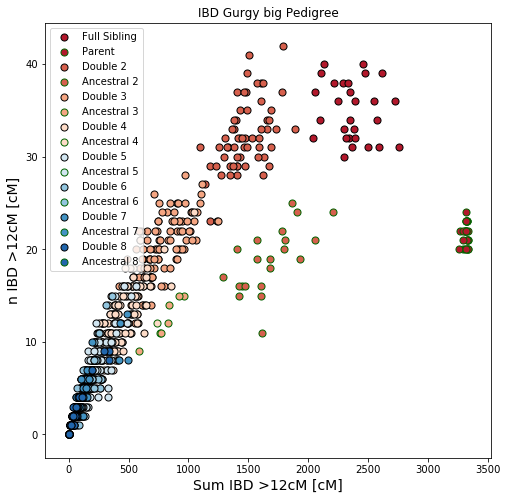

In [180]:
df_c = pd.read_csv("./data/tree/colors.tsv", sep="\t")
df1 = pd.read_csv("./output/ibd+rel.allv1.tsv", sep="\t")

min_cm = 12
s = 50
savepath = ""
figsize = (8,8)


plt.figure(figsize=figsize)
ax = plt.gca()

for _, row in df_c.iterrows():
    dft = df1[(df1["rel"]==row["rel"]) & (df1["anc"]==row["anc"])]
    
    if row["anc"]==1:
        ec = "darkgreen"
    else: ec = "k"

    ax.scatter(dft[f"sum_IBD>{min_cm}"], dft[f"n_IBD>{min_cm}"], s=s,
               ec=ec, linewidth=1, color=row["color"], label=row["label"])

ax.set_xlabel(f"Sum IBD >{min_cm}cM [cM]", fontsize=14)
ax.set_ylabel(f"n IBD >{min_cm}cM [cM]", fontsize=14)
#ax.set_xlim(xlim)
#ax.set_ylim(ylim)

ax.legend(loc="upper left")
if len(savepath)>0:
    plt.savefig(savepath, bbox_inches ='tight', pad_inches = 0, dpi=400)
    print(f"Saved to {savepath}")
ax.set_title("IBD Gurgy big Pedigree")

plt.show()

In [119]:
df1[df1["rel"]==2].sort_values(by="sum_IBD>12", ascending=False)[:50]

,iid1,iid2,rel,anc,max_IBD,sum_IBD>8,n_IBD>8,sum_IBD>12,n_IBD>12,sum_IBD>16,n_IBD>16,sum_IBD>20,n_IBD>20
579,GRG016,GRG078,2,1,180.888496,2779.824579,33.0,2759.389781,31.0,2747.189283,30.0,2728.364485,29.0
57,GRG015,GRG014,2,1,191.678904,2740.263206,37.0,2728.530506,36.0,2701.666609,34.0,2649.869811,31.0
743,GRG011,GRG034,2,1,182.314501,2621.808083,39.0,2621.808083,39.0,2578.620099,36.0,2562.563100,35.0
288,GRG068,GRG107,2,1,212.727589,2603.180171,32.0,2591.301871,31.0,2577.113873,30.0,2577.113873,30.0
1073,GRG026,GRG037,2,1,283.606503,2596.409449,36.0,2576.457649,34.0,2576.457649,34.0,2557.143350,33.0
433,GRG057,GRG034,2,1,224.558103,2572.753087,38.0,2554.984486,36.0,2529.185584,34.0,2529.185584,34.0
1459,GRG070,GRG075,2,1,213.983594,2532.893513,34.0,2502.640711,31.0,2490.110610,30.0,2471.317910,29.0
312,GRG068,GRG080,2,1,179.295300,2474.708491,39.0,2474.708491,39.0,2433.093985,36.0,2394.270285,34.0
1998,GRG094,GRG091,2,1,191.347104,2458.583303,40.0,2458.583303,40.0,2428.197892,38.0,2374.734099,35.0
1006,GRG107,GRG017,2,1,235.979289,2444.887891,37.0,2394.061385,32.0,2367.154485,30.0,2350.383181,29.0


### Plot Split up by relationship

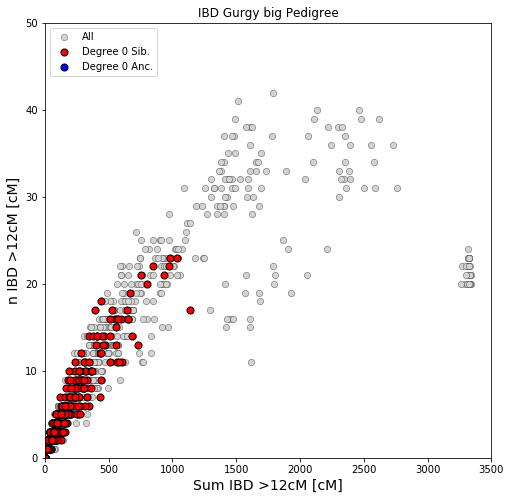

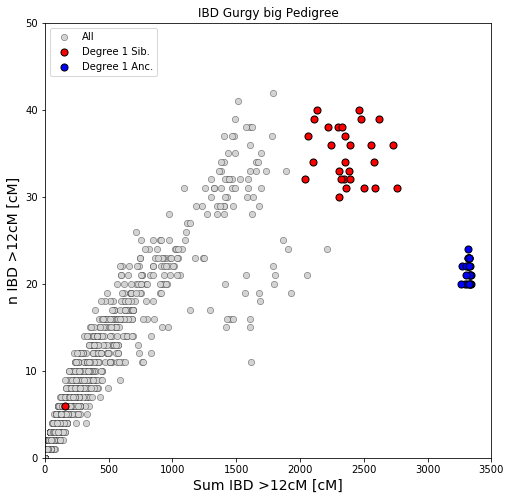

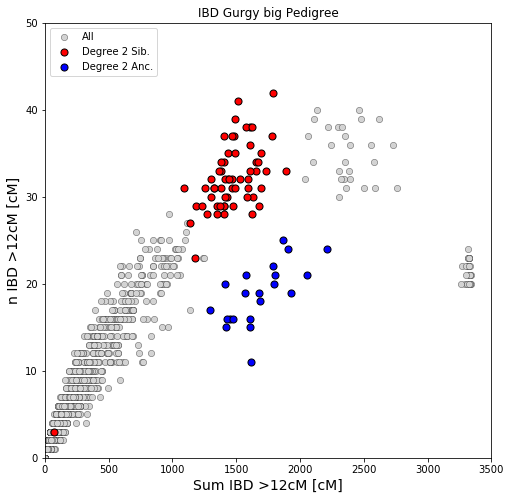

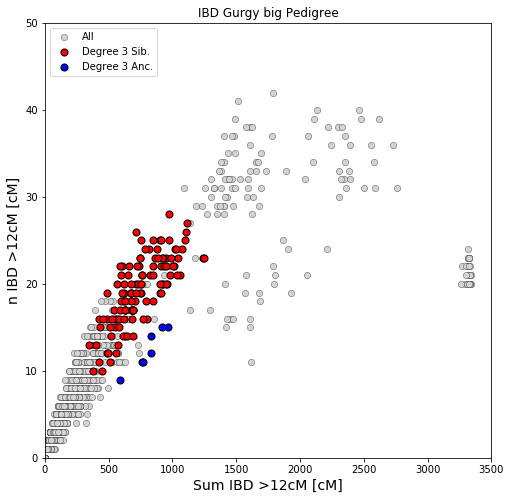

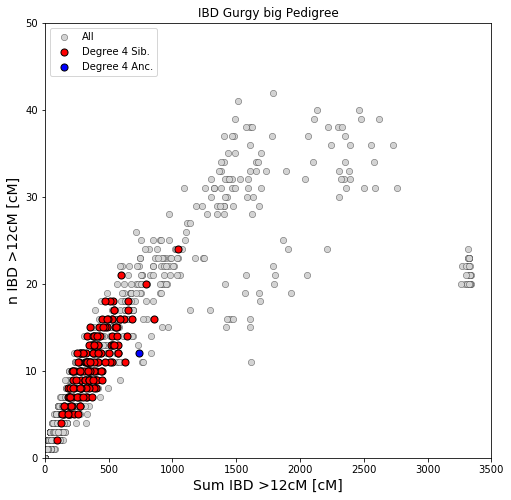

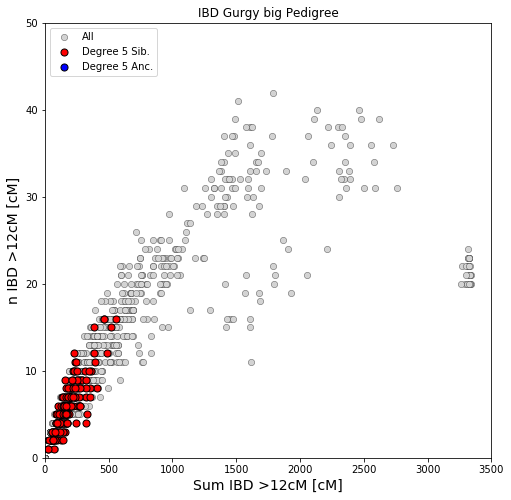

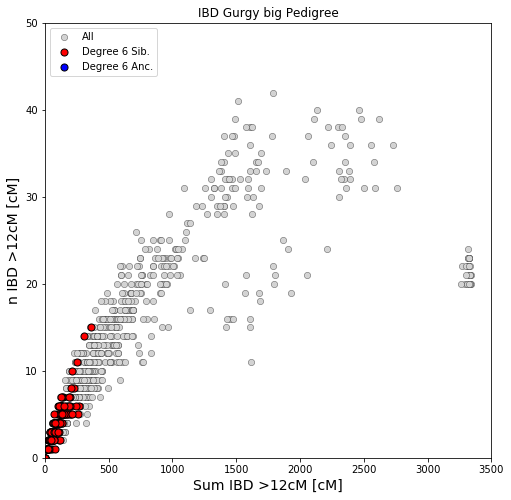

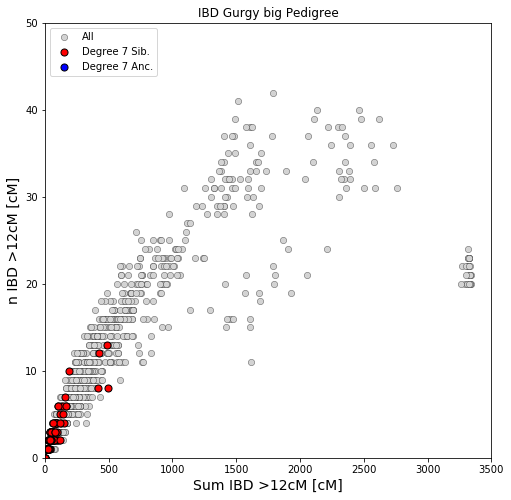

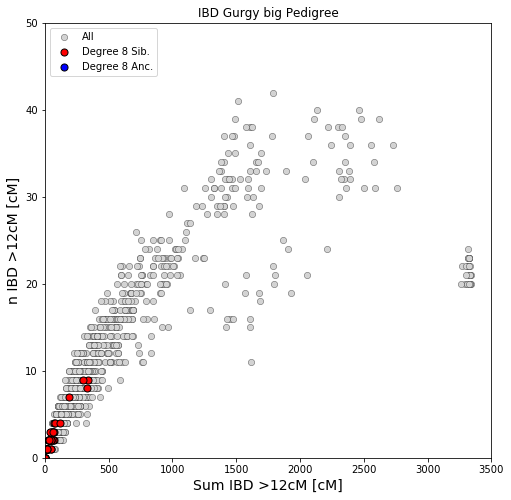

In [181]:
min_cm = 12
s = 50
s1= 40
savepath = ""
figsize = (8,8)
for r in range(0,9):
    savepath = f"./figs/ibd_scatter_rel{r}.png"
    savepath = ""

    plt.figure(figsize=figsize)
    ax = plt.gca()

    ax.scatter(df1[f"sum_IBD>{min_cm}"], df1[f"n_IBD>{min_cm}"], s=s1,
                   ec="k", linewidth=0.3, color="lightgray", label="All")

    dft = df1[(df1["rel"]==r) & (df1["anc"]==0)]
    ax.scatter(dft[f"sum_IBD>{min_cm}"], dft[f"n_IBD>{min_cm}"], s=s,
               ec="k", linewidth=1, color="red", label=f"Degree {r} Sib.")
    
    dft = df1[(df1["rel"]==r) & (df1["anc"]==1)]
    ax.scatter(dft[f"sum_IBD>{min_cm}"], dft[f"n_IBD>{min_cm}"], s=s,
               ec="k", linewidth=1, color="blue", label=f"Degree {r} Anc.")

    ax.set_xlabel(f"Sum IBD >{min_cm}cM [cM]", fontsize=14)
    ax.set_ylabel(f"n IBD >{min_cm}cM [cM]", fontsize=14)


    ax.legend(loc="upper left")
    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches ='tight', pad_inches = 0, dpi=400)
        print(f"Saved to {savepath}")
    ax.set_title("IBD Gurgy big Pedigree")
    
    ax.set_xlim([0,3500])
    ax.set_ylim([0,50])

    plt.show()

In [ ]:
dft.sort_values(by="sum_IBD>12", ascending=False)[:50]

In [ ]:
pd.merge(dft, df)

# Plot the full IBD distribution

# Screen for single IBD distribution

In [11]:
find_relatives(df1, iid="GRG027")

,iid1,iid2,rel,anc,max_IBD,sum_IBD>8,n_IBD>8,sum_IBD>12,n_IBD>12,sum_IBD>16,n_IBD>16,sum_IBD>20,n_IBD>20
0,GRG066,GRG027,1,1,280.864903,3328.534493,21.0,3328.534493,21.0,3328.534493,21.0,3328.534493,21.0
1,GRG107,GRG027,1,1,283.385103,3316.890079,22.0,3316.890079,22.0,3316.890079,22.0,3316.890079,22.0
2,GRG027,GRG013,2,1,211.841510,1793.620401,23.0,1785.515600,22.0,1770.537101,21.0,1770.537101,21.0
3,GRG027,GRG017,2,0,120.806795,1782.491398,38.0,1732.398095,33.0,1644.344793,27.0,1610.871881,25.0
4,GRG087,GRG027,2,1,186.801600,1606.490503,15.0,1606.490503,15.0,1606.490503,15.0,1606.490503,15.0
5,GRG080,GRG027,2,0,111.474204,1659.871541,41.0,1610.254334,36.0,1563.522542,33.0,1472.362824,28.0
6,GRG068,GRG027,2,0,116.019398,1451.733354,39.0,1400.373443,34.0,1342.964339,30.0,1308.030231,28.0
7,GRG027,GRG021,2,0,119.716299,1351.576365,34.0,1324.194265,31.0,1257.354977,26.0,1205.256381,23.0
8,GRG039,GRG027,2,0,106.589186,1279.469272,34.0,1252.153070,31.0,1180.629870,26.0,1144.916871,24.0
9,GRG002,GRG027,4,0,110.677505,1071.021010,27.0,1042.959611,24.0,1030.151610,23.0,1030.151610,23.0


In [103]:
find_relatives(df1, iid="GRG023")

,iid1,iid2,rel,anc,max_IBD,sum_IBD>8,n_IBD>8,sum_IBD>12,n_IBD>12,sum_IBD>16,n_IBD>16,sum_IBD>20,n_IBD>20


# Area 51

### Test Simple Pedigree for half sibs

In [57]:
df = pd.read_csv("./data/tree/family_all.v2.tsv", sep="\t")
#inds = set_up_node_list(df)

#d = get_relation_ship(name = "GRG087", name2 = "GRG084", 
#                      inds=inds, output=True)
#d

## 1) Cousins

In [67]:
df1 = pd.DataFrame({"t":["x", "y", "a", "b", "c", "d"], 
                   "f":["a", "n", "c", "c","n2", "n3"],
                   "m":["n8", "b", "d", "d", "n4", "n5"]})
inds = set_up_node_list(df1)

Created 6 empty Individuals


In [68]:
d = get_relation_ship(name = "x", name2 = "y", 
                      inds=inds, output=True)


Individual 1:
Crowling Node x
Crowling Node a
Crowling Node c
Crowling Node d

Individual 2:
Crowling Node y
Crowling Node b
Crowling Node c
Crowling Node d
2 2 1
Degree: 3, Via 1 line only: False


## 2) Half-Cousins

In [69]:
df1 = pd.DataFrame({"t":["x", "y", "a", "b", "c", "d"], 
                   "f":["a", "n", "c", "c","n2", "n3"],
                   "m":["n8", "b", "d", "n9", "n4", "n5"]})
inds = set_up_node_list(df1)

Created 6 empty Individuals


In [70]:
d = get_relation_ship(name = "x", name2 = "y", 
                      inds=inds, output=True)


Individual 1:
Crowling Node x
Crowling Node a
Crowling Node c
Crowling Node d

Individual 2:
Crowling Node y
Crowling Node b
Crowling Node c
2 2 0
Degree: 4, Via 1 line only: True
